In [ ]:
import numpy as np
import matplotlib.pyplot as plt

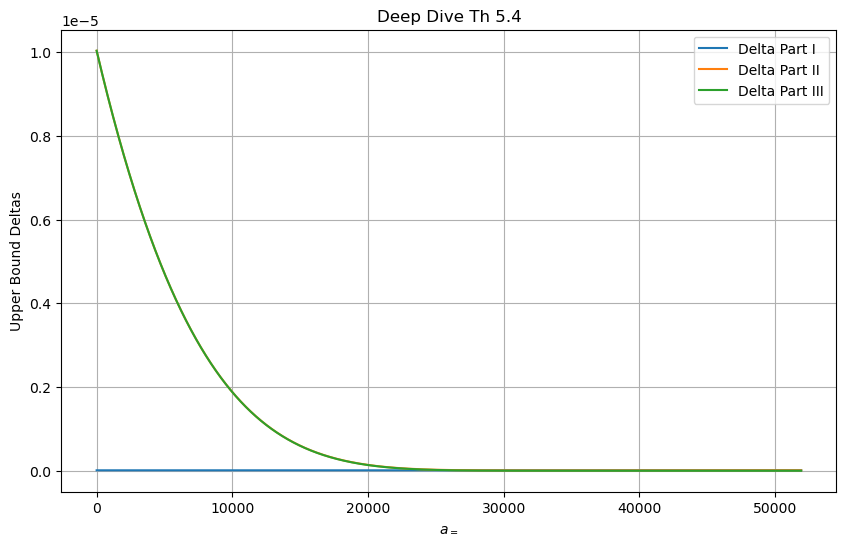

In [28]:
# TODO: Figure out differences \epsilon_1, ... _3

# This is a manually edited version of the ChatGPT o4 outout
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# global funcs
delta_analytic_gaussian = \
    lambda epsilon, mu :  norm.cdf(mu / 2 - epsilon / mu) - np.exp(epsilon) * norm.cdf(-mu / 2 - epsilon / mu)
delta_bw = \
     lambda epsilon, mu: norm.cdf(mu / 2 - epsilon / mu) - np.exp(epsilon) * norm.cdf(-mu / 2 - epsilon / mu)
tau_diff_func = \
    lambda delta, c_u, sigma: norm.ppf((1 - delta) ** (1 / c_u)) * sigma

# TODO: Replace with discrete gaussian.
def gshm_delta(c_u, sigma, tau_diff, epsilon):
    part_two = np.zeros(c_u)
    part_three = np.zeros(c_u)

    for i in range(1, c_u + 1):
        a_eq = i - 1
        mu = np.sqrt(c_u - a_eq) / sigma # p. 12
        epsilon2 = \
            epsilon - a_eq * np.log(norm.cdf(tau_diff / sigma)) # page 9
        epsilon3 = \
            epsilon + a_eq * np.log(norm.cdf(tau_diff / sigma)) # page 9

        part_two[i-1] = \
            1 - norm.cdf(tau_diff / sigma)**a_eq + norm.cdf(tau_diff / sigma)**a_eq * delta_analytic_gaussian(epsilon2, mu)
        part_three[i - 1] = delta_analytic_gaussian(epsilon3, mu)
    return [np.repeat(1 - norm.cdf(tau_diff / sigma)**c_u,c_u), 
                      part_two, 
                      part_three]
#c_u = 51914 # numURLs Contributed
c_u = 51914 # numURLs Contributed
#sigma = 2228
sigma = 2228
tau_diff = 16176
epsilon = 0.349
all_deltas = gshm_delta(c_u, sigma, tau_diff, epsilon)

# Figure A: Plotting delta for parameters in paper:
#  c_u 51914, sigma 2228, tau_diff = 16176, epsilon = 0.4

plt.figure(figsize=(10, 6))
x_values = range(1, c_u + 1)

plt.plot(x_values, all_deltas[0], label=f'Delta Part I')
plt.plot(x_values, all_deltas[1], label=f'Delta Part II')
plt.plot(x_values, all_deltas[2], label=f'Delta Part III')

plt.xlabel('$a_=$')
#plt.yscale("log")
plt.ylabel('Upper Bound Deltas')
plt.title('Deep Dive Th 5.4')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Initial Convert due to ChatGPT o4
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def delta_bw(epsilon, mu):
    return norm.cdf(mu / 2 - epsilon / mu) - np.exp(epsilon) * norm.cdf(-mu / 2 - epsilon / mu)

def tau_diff_func(delta, c_u, sigma):
    return norm.ppf((1 - delta) ** (1 / c_u)) * sigma

# Root Finder for mu
def findrootmu(candidate_mu, epsilon, delta):
    mu = candidate_mu
    for _ in range(100):
        f = delta_bw(epsilon, mu) - delta
        fp = (norm.pdf(mu / 2 - epsilon / mu) * (1 / 2 + epsilon / mu**2) - delta
              - np.exp(epsilon) * norm.pdf(-mu / 2 - epsilon / mu) * (-1 / 2 + epsilon / mu**2))
        mu = mu - f / fp
    return mu

# Root Finder for epsilon
def findroot(candidate_epsilon, mu, delta):
    epsilon = candidate_epsilon
    for _ in range(100):
        f = delta_bw(epsilon, mu) - delta
        fp = (norm.pdf(mu / 2 - epsilon / mu) * (-1 / mu)
              - np.exp(epsilon) * norm.cdf(-mu / 2 - epsilon / mu)
              - np.exp(epsilon) * norm.pdf(-mu / 2 - epsilon / mu) * (-1 / mu))
        epsilon = epsilon - f / fp
    return epsilon

# General Result
def gshm_delta(c_u, sigma, tau_diff, epsilon):
    delta_arr = np.zeros(c_u)
    delta_arr2 = np.zeros(c_u)

    for i in range(1, c_u + 1):
        a_eq = i - 1
        mu = np.sqrt(c_u - a_eq) / sigma
        epsilon2 = epsilon - a_eq * np.log(norm.cdf(tau_diff / sigma))
        f = delta_bw(epsilon2, mu)

        delta_arr[i - 1] = 1 - norm.cdf(tau_diff / sigma)**a_eq + norm.cdf(tau_diff / sigma)**a_eq * f
        epsilon3 = epsilon + a_eq * np.log(norm.cdf(tau_diff / sigma))
        delta_arr2[i - 1] = delta_bw(epsilon3, mu)

    final_delta = max(1 - norm.cdf(tau_diff / sigma)**c_u, max(delta_arr), max(delta_arr2))
    return final_delta

# Parameters
c_u = 51914
eps_views = 0.349
delta = 10**(-5)
k = np.sqrt(c_u)
mu_arr = 0
extra_y = 0

# Create sigma, tau curve
mu = findrootmu(np.sqrt(eps_views), eps_views, delta)
min_sigma = k / mu

mu = np.sqrt(mu**2 + np.sum(np.array(mu_arr)**2))
epsilon = findroot(0.01, mu, delta)

# Sigma values
sigma = np.concatenate((np.arange(0.01, 0.1, 0.01), np.arange(0.1, 300, 0.01)))
tau_diff = np.zeros(len(sigma))
tau_diff_gshm = np.zeros(len(sigma))

for i in range(len(sigma)):
    mu = k / sigma[i]
    mu = np.sqrt(mu**2 + np.sum(np.array(mu_arr)**2))
    delta_prime = delta_bw(epsilon, mu)
    delta_infinite = delta - delta_prime
    tau_diff[i] = tau_diff_func(delta_infinite, c_u, sigma[i])
    tau_diff_gshm[i] = tau_diff_func(delta, c_u, sigma[i])

# Check tau_diff meets target delta for GSHM
# Not sure where this is used.
tau_diff_gshm_check = []
for i in range(0, len(sigma), 500):
    tau_diff_gshm_check.append(abs(gshm_delta(c_u, sigma[i], tau_diff_gshm[i], epsilon) - delta) < delta**2)
accuracy = sum(tau_diff_gshm_check) / len(tau_diff_gshm_check) # not used.

# Plotting Figure A
min_y = min(np.min(tau_diff), np.min(tau_diff_gshm))
max_y = max(np.max(tau_diff), np.max(tau_diff_gshm))

plt.figure(figsize=(10, 6))
plt.plot(sigma, tau_diff, label="Add deltas", linewidth=2)
plt.plot(sigma[::10], tau_diff_gshm[::10], color="blue", linestyle="--", linewidth=2, label="GSHM")
plt.axvline(x=round(min_sigma), color="gray", linestyle=":", label=f"$\sigma = {round(min_sigma)}$")
plt.ylim(min_y, max_y + extra_y)
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\tau^* - \tau$")
plt.legend()
plt.grid(True)
plt.show()

# Parameters for epsilon-delta curves
delta_infinite = 10**(-8)
sigma = np.sqrt(c_u) / mu
eps_max = findroot(0.01, mu, delta_infinite)

# Delta-epsilon values for points on curve
delta_plot_vals = 10**np.arange(-8, -4, 1)
eps_plot_vals = [findroot(0.01, mu, dpv) for dpv in delta_plot_vals]

# Delta curves calculation
delta_arr_add_deltas_plot_vals = []
delta_arr_gshm_plot_vals = []
annotations = []

for eps in eps_plot_vals:
    delta_add = delta_bw(eps, mu) + delta_infinite
    tau_diff = tau_diff_func(delta_infinite, c_u, sigma)
    delta_gshm = gshm_delta(c_u, sigma, tau_diff, eps)
    delta_arr_add_deltas_plot_vals.append(delta_add)
    delta_arr_gshm_plot_vals.append(delta_gshm)
    annotations.append(f"$\delta_{{GSHM}}={round(delta_gshm, -int(np.log10(delta_gshm)))}$")

KeyboardInterrupt: 